# Modeling with random forest

In [1]:
#importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
#reading the data
data=pd.read_csv('Data/DirectMarketing_Cln_Classification.csv')

In [3]:
#shape of the data
data.shape

(1000, 15)

In [4]:
#first five rows of the data
data.head()

,Salary,Children,Catalogs,Middle,Old,Young,Female,Male,Own,Rent,Married,Single,Close,Far,Amt_Spnt_Class
0,47500,0,6,0,1,0,1,0,1,0,0,1,0,1,Low
1,63600,0,6,1,0,0,0,1,0,1,0,1,1,0,Med
2,13500,0,18,0,0,1,1,0,0,1,0,1,1,0,Low
3,85600,1,18,1,0,0,0,1,1,0,1,0,1,0,High
4,68400,0,12,1,0,0,1,0,1,0,0,1,1,0,Med


In [5]:
print(data.columns)

Index(['Salary', 'Children', 'Catalogs', 'Middle', 'Old', 'Young', 'Female',
       'Male', 'Own', 'Rent', 'Married', 'Single', 'Close', 'Far',
       'Amt_Spnt_Class'],
      dtype='object')


In [6]:
#checking missing values in the data
data.isnull().sum()

Salary            0
Children          0
Catalogs          0
Middle            0
Old               0
Young             0
Female            0
Male              0
Own               0
Rent              0
Married           0
Single            0
Close             0
Far               0
Amt_Spnt_Class    0
dtype: int64

In [7]:
#seperating independent and dependent variables
X = data.drop(['Amt_Spnt_Class'], axis=1)
y = data['Amt_Spnt_Class']


In [8]:
print(X)

     Salary  Children  Catalogs  Middle  Old  Young  Female  Male  Own  Rent  \
0     47500         0         6       0    1      0       1     0    1     0   
1     63600         0         6       1    0      0       0     1    0     1   
2     13500         0        18       0    0      1       1     0    0     1   
3     85600         1        18       1    0      0       0     1    1     0   
4     68400         0        12       1    0      0       1     0    1     0   
..      ...       ...       ...     ...  ...    ...     ...   ...  ...   ...   
995   19400         1        18       0    0      1       1     0    0     1   
996   40500         1        18       1    0      0       0     1    0     1   
997   44800         0        24       0    1      0       0     1    1     0   
998   79000         2        18       1    0      0       0     1    1     0   
999   53600         1        24       0    0      1       0     1    0     1   

     Married  Single  Close  Far  
0   

In [9]:
print(y)

0       Low
1       Med
2       Low
3      High
4       Med
       ... 
995     Low
996     Med
997     Med
998     Low
999     Med
Name: Amt_Spnt_Class, Length: 1000, dtype: object


In [10]:
#importing train_test_split to create validation set
from sklearn.model_selection import train_test_split

In [11]:
#creating the train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, stratify=y, test_size=0.20)

In [12]:
# distribution in training set
y_train.value_counts(normalize=True)

Low     0.50125
High    0.25000
Med     0.24875
Name: Amt_Spnt_Class, dtype: float64

In [13]:
# distribution in validation set
y_valid.value_counts(normalize=True)

Low     0.50
High    0.25
Med     0.25
Name: Amt_Spnt_Class, dtype: float64

In [14]:
#shape of training set
X_train.shape, y_train.shape

((800, 14), (800,))

In [15]:
#shape of validation set
X_valid.shape, y_valid.shape

((200, 14), (200,))

## Random Forest Classifier


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Baseline Random Forest

In [17]:
# intiate random forest classifier
rfc_1 = RandomForestClassifier(random_state = 1)

# fit the training set
rfc_1.fit(X_train, y_train)

display(rfc_1.score(X_train, y_train))

C:\Users\Torrey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.97

In [18]:
# extract feature importances by gini score 
feats = {}
for feature, importance in zip(data.columns, rfc_1.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

display(importances)

,Features,Gini-Importance
0,Salary,0.415964
1,Catalogs,0.161579
2,Children,0.088574
3,Single,0.046391
4,Own,0.034133
5,Close,0.033751
6,Married,0.032890
7,Young,0.032855
8,Middle,0.031027
9,Far,0.030950


In [19]:
y_pred = rfc_1.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.795

## Random Search CV

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
rfc_2 = RandomForestClassifier(random_state = 1)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rfc_2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   43.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [22]:
rf_random.best_params_

{'n_estimators': 1577,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

## Model with Random Search CV Params

In [23]:
rfc_3 = RandomForestClassifier(n_estimators = 1577,
                               min_samples_split = 10,
                               min_samples_leaf = 1,
                               max_features = 'sqrt',
                               max_depth = 20,
                               bootstrap = True)

In [24]:
# fit the training set
rfc_3.fit(X_train, y_train)

display(rfc_3.score(X_train, y_train))

0.8725

In [25]:
y_pred = rfc_3.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.82

## Confusion Matrix & Accuracy

In [26]:
# confusion matrix
conf_matrix_rf = pd.DataFrame(confusion_matrix(y_valid, y_pred, labels=['High','Med','Low']), index = ['actual high', 'actual med', 'actual low'], 
                               columns = ['predicted high', 'predicted med', 'predicted low'])

conf_matrix_rf

,predicted high,predicted med,predicted low
actual high,41,7,2
actual med,8,28,14
actual low,0,5,95


In [27]:
# accuracy score
accuracy_score(y_valid, y_pred)

0.82

In [28]:
# recall
recall_score(y_valid, y_pred, average=None)

array([0.82, 0.95, 0.56])

In [29]:
# precision score
precision_score(y_valid, y_pred, average=None)

array([0.83673469, 0.85585586, 0.7       ])

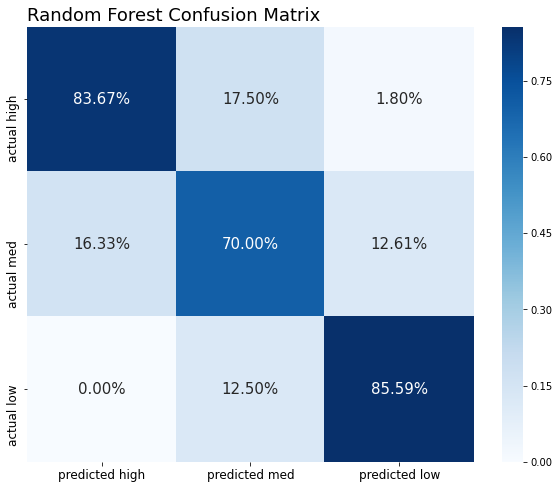

In [38]:
fig, ax = plt.subplots(figsize = (10,8))


sns.heatmap(conf_matrix_rf/np.sum(conf_matrix_rf), annot=True, 
            fmt='.2%', cmap='Blues', annot_kws={'size':15})

ax.set_title('Random Forest Confusion Matrix', fontsize = 18, loc='left')

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)

plt.show()

Resources:

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74